In [1]:
from IPython.display import clear_output
from datetime import datetime

import os
from os.path import join as opj
import numpy as np
import healpy as hp

from delensalot.utility.utils_hp import almxfl, alm_copy
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from delensalot.run import run

from delensalot.utility import plot_helper as ph

bpl, bpu = (1,1000)
def scale_and_bandpass(data):
    ll = np.arange(0,3001)
    return ph.bandpass_alms(hp.almxfl(data,np.sqrt(ll*(ll+1))), bpl, bpu)

fn = opj(os.getcwd(), 'conf_checkdc08.py')
fn = opj(os.getcwd(), 'conf_checkdc08_oldtniti.py')
# fn = opj(os.getcwd(), 'conf_checkdc08_noOBD.py')

mpisupport: False, pmisupport: False
disabling mpi
mpi.py: Plancklens.mpi disabled as per environ variable 



In [2]:
delensalot_runner = run(config_fn=fn, job_id='MAP_lensrec', verbose=False)
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

from delensalot.core.iterator.statics import rec as rec

Cell finished 02:23:37


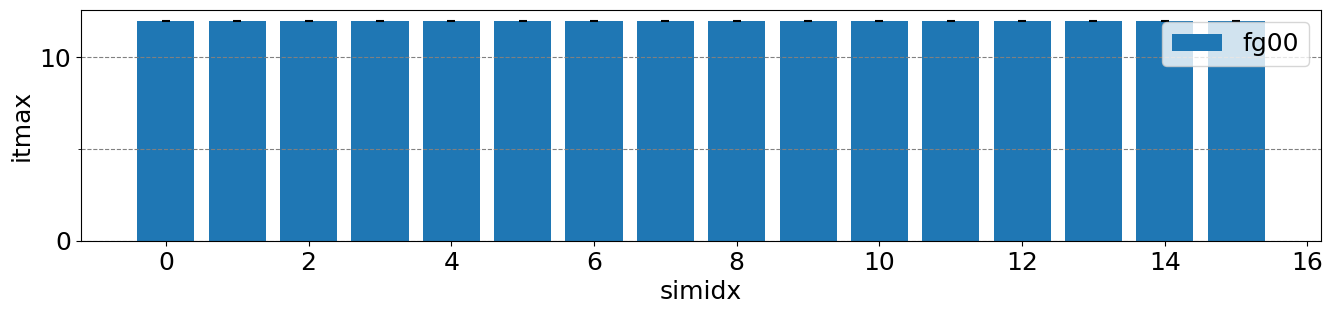

In [3]:
# import pandas as pd
def status():
    fig = plt.figure(figsize=(16, 3))
    out = {}
    itmax_loc = ana_mwe.itmax
    buffer = []
    for simidx in ana_mwe.simidxs:
        test = [rec.maxiterdone(ana_mwe.libdir_MAP(ana_mwe.k, simidx, ana_mwe.version)) >= itmax_loc]
        if np.all(test):
            buffer.append(itmax_loc)
        else:
            buffer.append(rec.maxiterdone(ana_mwe.libdir_MAP(ana_mwe.k, simidx, ana_mwe.version)))
    out.update({'fg00': np.array(buffer)})
    plt.bar(np.arange(0,len(out['fg00'])), height=out['fg00'], label='fg00')

    # pdf = pd.DataFrame(out)
    # pdf.plot.bar(xlabel='simidx', ylabel='Rec. iteration', figsize=(16, 2), ylim=(0,20), title='Status analyses: {}'.format(whoami.split('.')[0][13:-3]))
    plt.scatter(ana_mwe.simidxs, np.ones_like(ana_mwe.simidxs)*itmax_loc, color='black', marker='_')
    plt.grid(which='both', axis='y', ls= '--', color='grey')
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    plt.xlabel('simidx')
    plt.ylabel('itmax')
    plt.legend()
status()

## Make mask

In [3]:
mask = hp.read_map(opj(os.environ['CFS'], 'cmbs4/awg/lowellbb/reanalysis/foreground_cleaned_maps/08b.00_umilta_210511/ILC_mask_08b_smooth_30arcmin.fits'))
mask_pos = hp.read_map('/pscratch/sd/s/sebibel/data/cmbs4/reanalysis/mapphi_intermediate/s08b/masks/08b_rhits_positive_nonan.fits')
mask_from_rhits = hp.read_map(opj(os.environ['SCRATCH'], 'cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08b/masks/08b_mask_from_rhits.fits'))

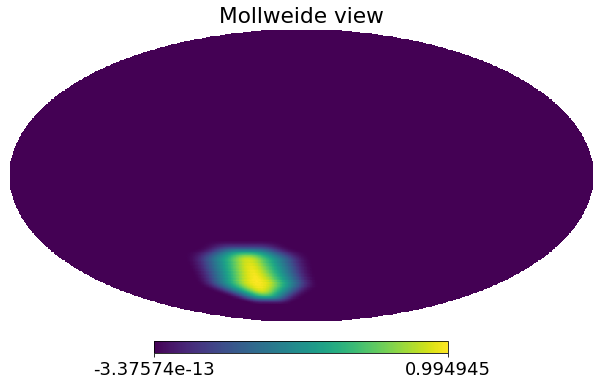

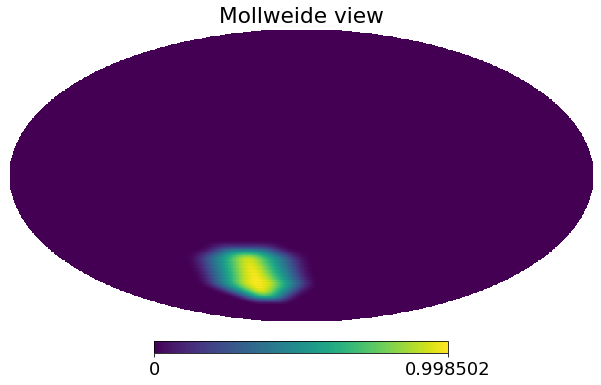

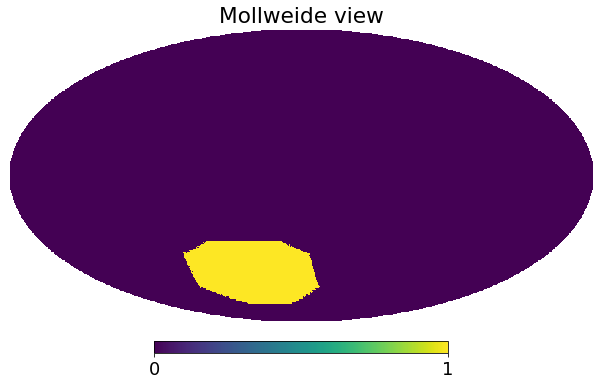

In [4]:
hp.mollview(mask)
hp.mollview(mask_pos)
hp.mollview(mask_from_rhits)

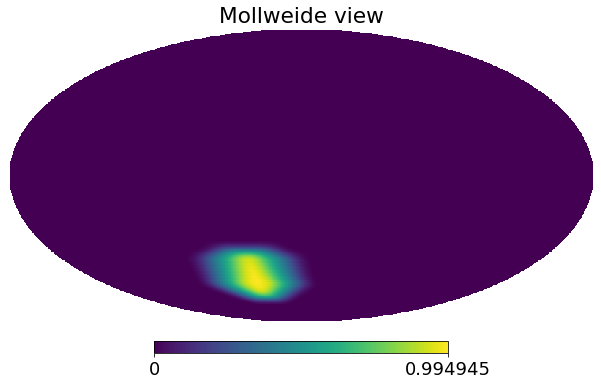

In [7]:
mask_fix = np.where(mask<0,0,mask)
hp.mollview(mask_fix)

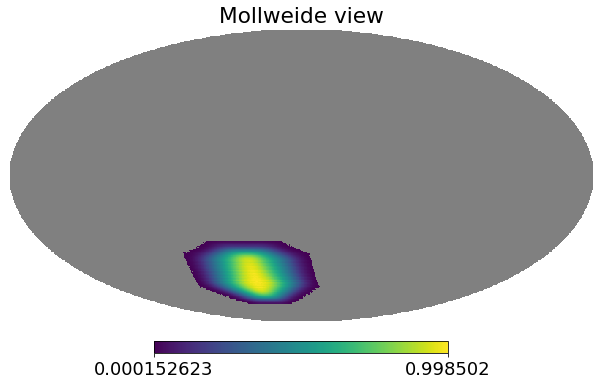

In [5]:
rhits = hp.read_map(opj(os.environ['CFS'], 'cmbs4/awg/lowellbb/expt_xx/08b/rhits/n2048.fits'))
hp.mollview(rhits)

In [32]:
os.makedirs(opj(os.environ['SCRATCH'], 'cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08b/masks/'))
hp.write_map(opj(os.environ['SCRATCH'], 'cmbs4/awg/lowellbb/reanalysis/mapphi_intermediate/s08b/masks/08b_mask_from_rhits.fits'),np.where(mask_pos>0,1,0))

## Check QE res

In [6]:
delensalot_runner = run(config_fn=fn, job_id='QE_lensrec', verbose=False)
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 10:54:41


INFO:: 08-15 00:21:25:: delensalot.sims.sims_lib.get_sim_obs - requesting "obs_spacemap_spin2_fieldpolarization_0"
INFO:: 08-15 00:21:25:: delensalot.sims.sims_lib.get_sim_obs - ..nothing cached..
INFO:: 08-15 00:21:25:: delensalot.sims.sims_lib.get_sim_obs - .., but stored on disk.
applying func to data
applying func to data
INFO:: 08-15 00:21:28:: delensalot.sims.sims_lib.get_sim_obs - requesting "obs_spacemap_spin2_fieldpolarization_0"
INFO:: 08-15 00:21:28:: delensalot.sims.sims_lib.get_sim_obs - found "obs_spacemap_spin2_fieldpolarization_0"


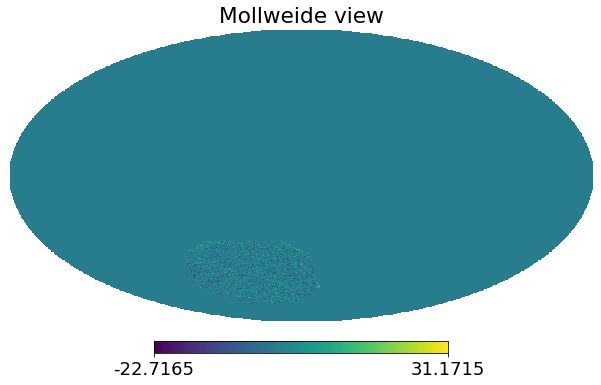

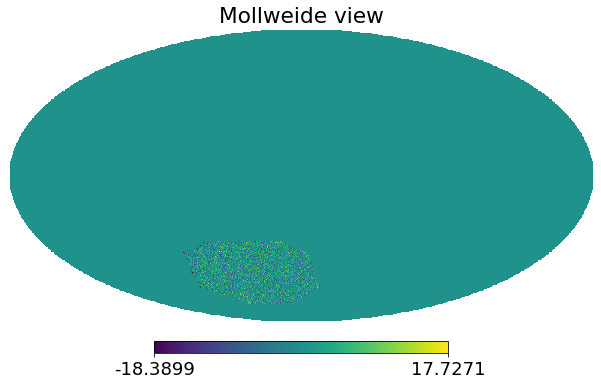

In [3]:
hp.mollview(ana_mwe.simulationdata.get_sim_pmap(0)[0])
hp.mollview(ana_mwe.simulationdata.get_sim_pmap(0)[1])

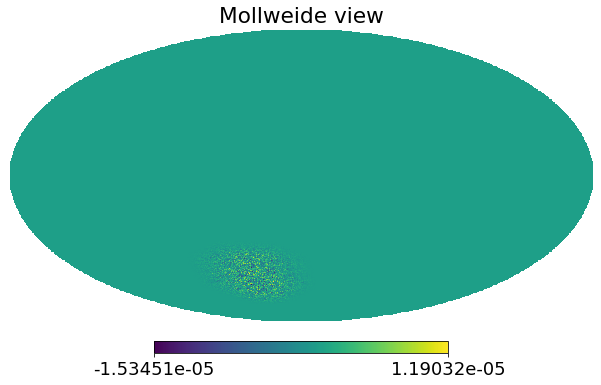

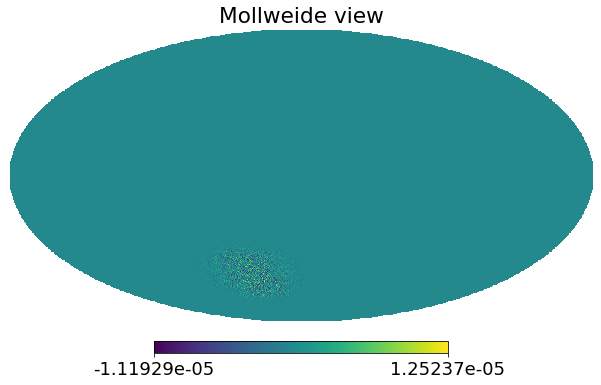

In [8]:
Qmap = hp.read_map(ana_mwe.simulationdata.libdir+ana_mwe.simulationdata.fns['Q'].format(0),field=1)
Umap = hp.read_map(ana_mwe.simulationdata.libdir+ana_mwe.simulationdata.fns['U'].format(0),field=2)
hp.mollview(Qmap)
hp.mollview(Umap)

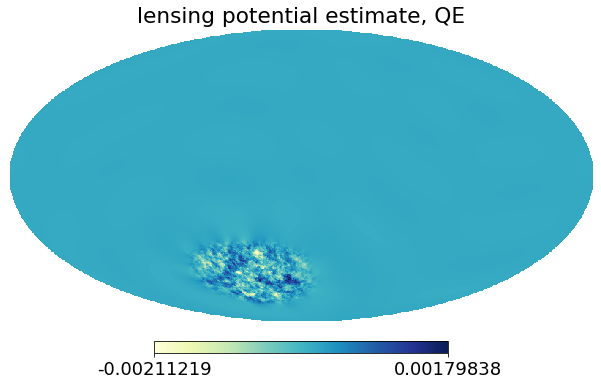

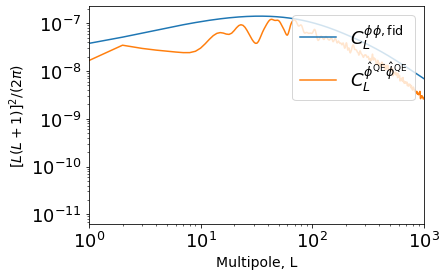

In [5]:
plm_QE = ana_mwe.get_plm(0, [0])
LL = np.arange(0,ana_mwe.lm_max_qlm[0]+1,1)
scale_factor_L = (LL*(LL+1))**2/(2*np.pi)
mask = hp.read_map(ana_mwe.mask_fn)
hp.mollview(hp.alm2map(scale_and_bandpass(plm_QE), nside=256), title='lensing potential estimate, QE', cmap='YlGnBu')
plt.show()

plt.plot(scale_factor_L*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
plt.plot(scale_factor_L*hp.alm2cl(plm_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')

plt.legend(fontsize=18, loc='upper right')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
# plt.ylim(1e-9,1e-6)
plt.yscale('log')

## Run

In [33]:
delensalot_runner = run(config_fn=fn, job_id='build_OBD', verbose=True)
delensalot_runner.run()
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 01:55:19


In [2]:
delensalot_runner = run(config_fn=fn, job_id='generate_sim', verbose=True)
delensalot_runner.run()
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 02:54:07


In [2]:
delensalot_runner = run(config_fn=fn, job_id='QE_lensrec', verbose=False)
delensalot_runner.run()
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 14:14:39


In [ ]:
delensalot_runner = run(config_fn=fn, job_id='MAP_lensrec', verbose=False)
delensalot_runner.run()
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

INFO:: 08-15 00:26:08:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 08-15 00:26:08:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds
INFO:: 08-15 00:26:08:: delensalot.config.handler.store - /global/u2/s/sebibel/git/notebooks/cmbs4/dc09/validate_dc08/conf_checkdc08_oldtniti.py
INFO:: 08-15 00:26:08:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 08-15 00:26:08:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds
INFO:: 08-15 00:26:08:: root.store - config file comparison done. No conflicts found.
INFO:: 08-15 00:26:08:: root.store - Matching config file found. Resuming where I left off.
INFO:: 08-15 00:26:08:: root.store - /pscratch/sd/s/sebibel/analy

KeyboardInterrupt: 

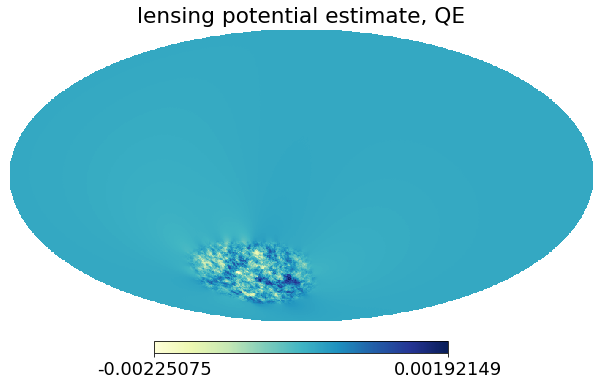

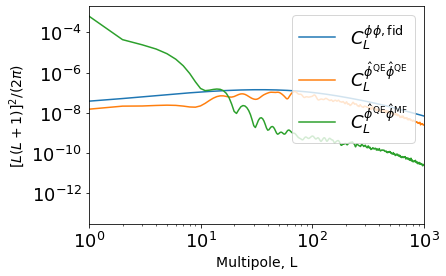

In [7]:
mf_QE = ana_mwe.get_meanfield_normalized(0)
plm_QE = ana_mwe.get_plm_it(0, [0])[0]

LL = np.arange(0,ana_mwe.lm_max_qlm[0]+1,1)
scale_factor_L = (LL*(LL+1))**2/(2*np.pi)
mask = hp.read_map(ana_mwe.mask_fn)

hp.mollview(hp.alm2map(scale_and_bandpass(plm_QE), nside=256), title='lensing potential estimate, QE', cmap='YlGnBu')
plt.show()

plt.plot(scale_factor_L*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
plt.plot(scale_factor_L*hp.alm2cl(plm_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
plt.plot(scale_factor_L*hp.alm2cl(mf_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm MF}}$')

plt.legend(fontsize=18, loc='upper right')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
# plt.ylim(1e-9,1e-6)
plt.yscale('log')

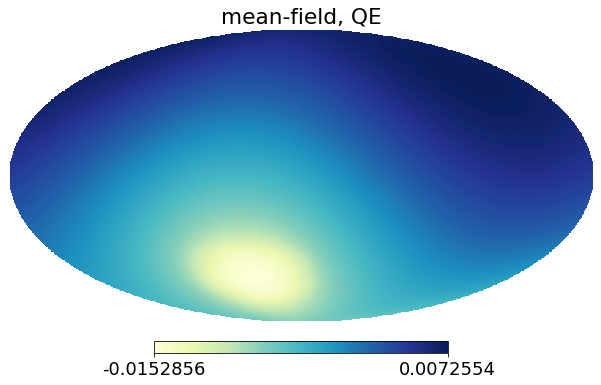

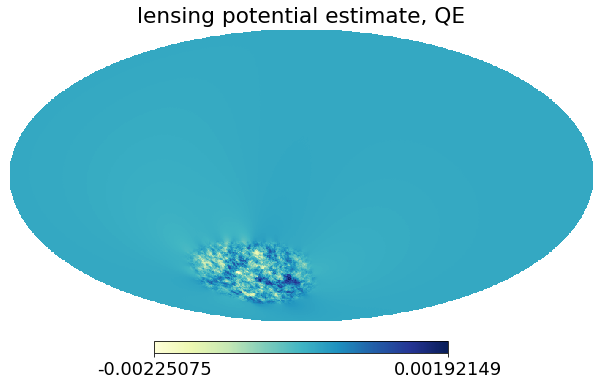

In [8]:
hp.mollview(hp.alm2map(scale_and_bandpass(mf_QE), nside=256), title='mean-field, QE', cmap='YlGnBu')
hp.mollview(hp.alm2map(scale_and_bandpass(plm_QE), nside=256), title='lensing potential estimate, QE', cmap='YlGnBu')

## Check MAP res

In [13]:
delensalot_runner = run(config_fn=fn, job_id='MAP_lensrec', verbose=False)
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 13:20:14


DEBUG:: 08-15 13:52:12:: delensalot.core.handler.log - collect_jobs() started
DEBUG:: 08-15 13:52:12:: delensalot.core.handler.log - collect_jobs() finished
DEBUG:: 08-15 13:52:12:: delensalot.core.handler.log - collect_jobs() started
DEBUG:: 08-15 13:52:13:: delensalot.core.handler.log - collect_jobs() finished


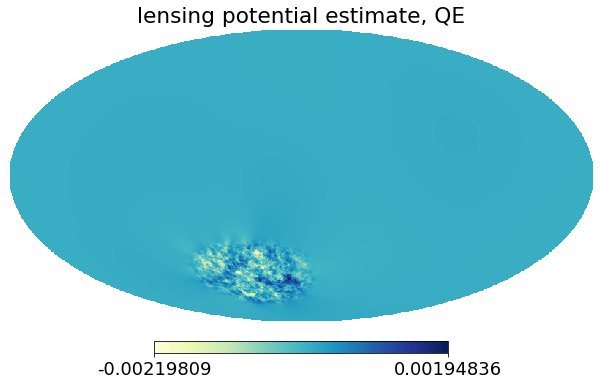

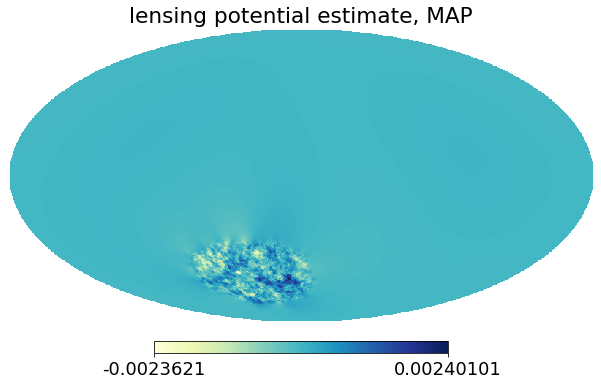

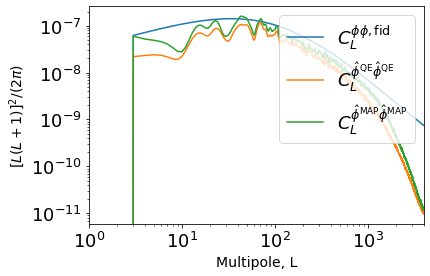

In [21]:
plm_QE = ana_mwe.get_plm_it(0, [0])[0]
plm_MAP = ana_mwe.get_plm_it(0, [12])[0]

LL = np.arange(0,ana_mwe.lm_max_qlm[0]+1,1)
scale_factor_L = (LL*(LL+1))**2/(2*np.pi)
mask = hp.read_map(ana_mwe.mask_fn)

hp.mollview(hp.alm2map(scale_and_bandpass(plm_QE), nside=256), title='lensing potential estimate, QE', cmap='YlGnBu')
hp.mollview(hp.alm2map(scale_and_bandpass(plm_MAP), nside=256), title='lensing potential estimate, MAP', cmap='YlGnBu')
plt.show()

plt.plot(scale_factor_L*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
plt.plot(scale_factor_L*hp.alm2cl(plm_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
plt.plot(scale_factor_L*hp.alm2cl(plm_MAP)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')

plt.legend(fontsize=18, loc='upper right')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,4e3)
# plt.ylim(1e-9,1e-6)
plt.yscale('log')

## delens

In [2]:
delensalot_runner = run(config_fn=fn, job_id='delens', verbose=True)
delensalot_runner.run()
ana_mwe = delensalot_runner.init_job()

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Cell finished 03:27:09


In [3]:
Blensing_index, QEdel_index, MAPdel_index = 0, 1, 2
mask_index = 0

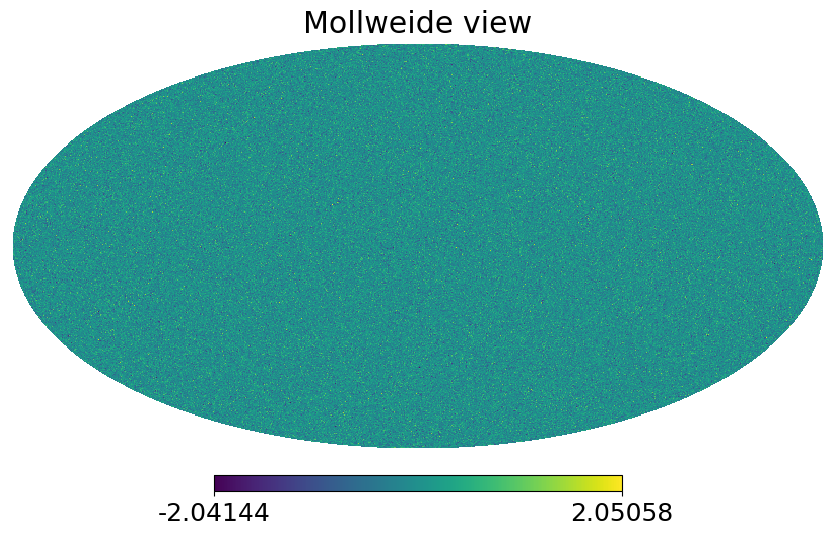

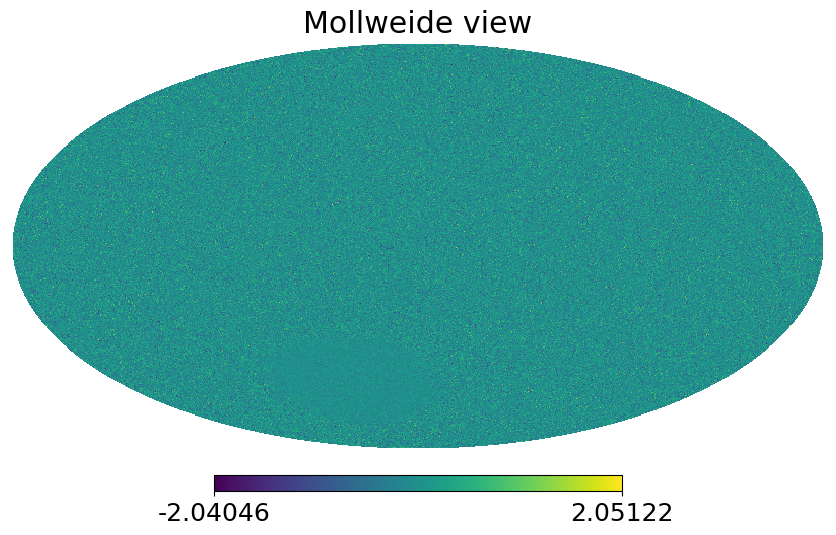

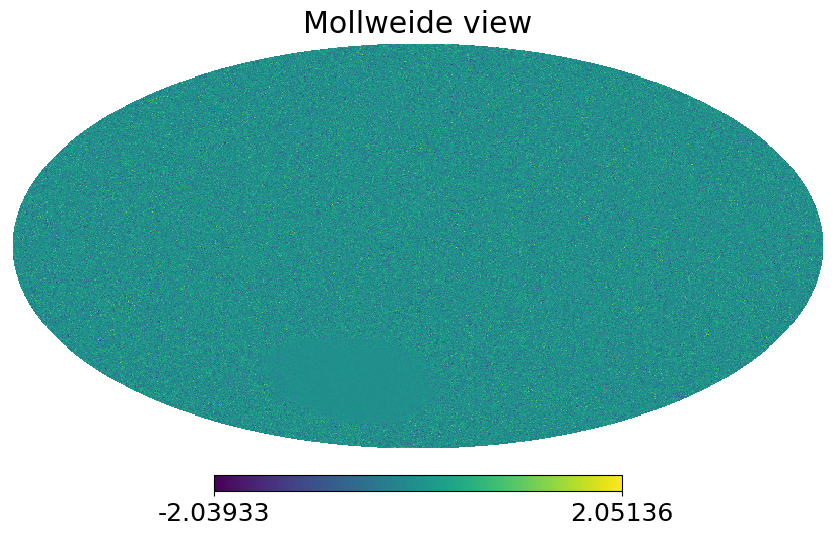

In [4]:
from plancklens.sims import planck2018_sims
from delensalot.utility.utils_hp import Alm, almxfl, alm_copy, gauss_beam
input_blensing = hp.almxfl(alm_copy(planck2018_sims.cmb_len_ffp10.get_sim_blm(0), None, lmaxout=1024, mmaxout=1024), gauss_beam(2.3 / 180 / 60 * np.pi, lmax=1024))

blens_residual_QE = ana_mwe.get_residualblens(ana_mwe.simidxs[0], 0)
blens_residual_MAP = ana_mwe.get_residualblens(ana_mwe.simidxs[0], ana_mwe.its[-1])

clbb = ana_mwe.read_data()

hp.mollview(hp.alm2map(input_blensing, nside=256))
hp.mollview(hp.alm2map(blens_residual_QE, nside=256))
hp.mollview(hp.alm2map(blens_residual_MAP, nside=256))

Text(0, 0.5, '$C_\\ell [\\mu $$\\rm{K}^2$]')

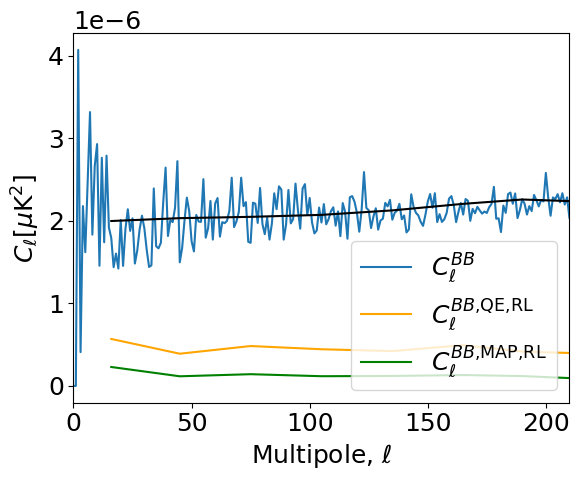

In [5]:
plt.plot(hp.alm2cl(input_blensing, lmax_out=ana_mwe.lm_max_blt[0]), label=r'$C_\ell^{BB}$')
clbb_QEavg = np.mean(clbb[QEdel_index,mask_index,:,:],axis=0)
clbb_MAPavg = np.mean(clbb[MAPdel_index,mask_index,:,:],axis=0)
plt.plot(ana_mwe.edges_center, ana_mwe.ct[1:], color='black')
plt.plot(ana_mwe.edges_center, clbb_QEavg*ana_mwe.ct[1:], color='orange', label=r'$C_\ell^{BB{,}{\rm QE{,}RL}}$')
plt.plot(ana_mwe.edges_center, clbb_MAPavg*ana_mwe.ct[1:], color='green', label=r'$C_\ell^{BB{,}{\rm MAP{,}RL}}$')

plt.legend(loc='lower right')
plt.xlim(0,210)
# plt.ylim(1e-7,1e-5)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')

In [6]:
binlmin, binlmax = (1, 7)
lmin, lmax = (30, 180)
Alens_QE = np.mean(clbb_QEavg[binlmin:binlmax]*ana_mwe.ct[binlmin:binlmax])/np.mean(hp.alm2cl(input_blensing, lmax_out=lmax)[lmin:lmax])
Alens_MAP = np.mean(clbb_MAPavg[binlmin:binlmax]*ana_mwe.ct[binlmin:binlmax])/np.mean(hp.alm2cl(input_blensing, lmax_out=lmax)[lmin:lmax]) 
print(20*'~.')
print(':::Empiric:::')
print('nlev: {}, lmax_ivf: {}, beam: {} arcmin '.format(str(ana_mwe.nlev), ana_mwe.lm_max_ivf, ana_mwe.beam))
print("A_L^QE: {:.3f}, A_L^MAP: {:.3f}".format(Alens_QE, Alens_MAP))
print(20*'~.')

~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
:::Empiric:::
nlev: {'P': 0.42, 'T': 1.0}, lmax_ivf: (4000, 4000), beam: 2.3 arcmin 
A_L^QE: 0.208, A_L^MAP: 0.059
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.


## invert tnit

In [7]:
tnit = np.load('/pscratch/sd/s/sebibel/analysis/OBDmatrix/checkdc08/nside2048/tnit.npy')
# np.linalg.inv(tnit[::20,::20])
# plt.imshow(tnit)

In [15]:
(0.42/0.3505)**2

1.4358945138491783

In [ ]:
lmax_marg = 180
int((lmax_marg + 1) * lmax_marg + lmax_marg + 1 - 4)